In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
import mpl_toolkits.axes_grid1

from mpl_toolkits import basemap

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

In [2]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [3]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]
year_start = 1920
year_end = 2100

In [4]:
year_start_list = numpy.arange(1920,2071)
year_end_list = numpy.arange(1950,2101)

whiplash_ratios_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_pic_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_rcp_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))

# create list of names of members '001','002','003', ...
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'

In [5]:
# create season strings
years_hist_rcp = numpy.arange(1920, 2100+1, 1).astype(numpy.int)

idx_2003 = numpy.where(years_hist_rcp==2003)[0][0]
idx_2033 = numpy.where(years_hist_rcp==2033)[0][0]
idx_2070 = numpy.where(years_hist_rcp==2070)[0][0]
idx_2100 = numpy.where(years_hist_rcp==2100)[0][0]

season_strings_hist_rcp = [str(years_hist_rcp[i])+'-'+str(years_hist_rcp[i+1]) for i in range(years_hist_rcp.size-1)]
#print(season_strings_hist_rcp[idx_2003:idx_2033])

n_seasons_hist_rcp = 2100-1920
#print(len(season_strings_hist_rcp))

In [6]:
# import monthly pic data
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain_MONTHLY_TOTALS/'
monthly_data_pic = numpy.load(working_dir+'member_005_years_0402-2200_threshold_0.1mmday_whole_domain.npy')
#print(monthly_data_pic.shape)
# (26, 25, 1799, 12)

monthly_data_pic_NDJFM = numpy.zeros((26,25,1798,5))

monthly_data_pic_NDJFM[:,:,:,0] = monthly_data_pic[:,:,:1798,10]
monthly_data_pic_NDJFM[:,:,:,1] = monthly_data_pic[:,:,:1798,11]
monthly_data_pic_NDJFM[:,:,:,2] = monthly_data_pic[:,:,1:,0]
monthly_data_pic_NDJFM[:,:,:,3] = monthly_data_pic[:,:,1:,1]
monthly_data_pic_NDJFM[:,:,:,4] = monthly_data_pic[:,:,1:,2]

In [7]:
# import monthly RCP data
monthly_data_hist_rcp = []
for ens_name in ensemble_names:
    monthly_data_hist_rcp.append(numpy.load(working_dir+'PRECT_monthly_data_member_' +ens_name+ '_years_1920-2100_threshold_0.1mmday_whole_domain.npy'))
monthly_data_hist_rcp = numpy.array((monthly_data_hist_rcp))
#print(monthly_data_hist_rcp.shape)
# (40, 26, 25, 181, 12)

# store just NDJFM
monthly_data_hist_rcp_NDJFM = numpy.zeros((40,26,25,180,12))
monthly_data_hist_rcp_NDJFM[:,:,:,:,0] = monthly_data_hist_rcp[:,:,:,:180,10]
monthly_data_hist_rcp_NDJFM[:,:,:,:,1] = monthly_data_hist_rcp[:,:,:,:180,11]
monthly_data_hist_rcp_NDJFM[:,:,:,:,2] = monthly_data_hist_rcp[:,:,:,1:,0]
monthly_data_hist_rcp_NDJFM[:,:,:,:,3] = monthly_data_hist_rcp[:,:,:,1:,1]
monthly_data_hist_rcp_NDJFM[:,:,:,:,4] = monthly_data_hist_rcp[:,:,:,1:,2]

In [113]:
# calculate 80th, 20th percentiles for PIC for each month
hi_perc = 90
lo_perc = 10
pic_hi_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM, hi_perc, axis=2) # 26x25x5
pic_lo_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM, lo_perc, axis=2) # 26x25x5

In [114]:
# whiplash events for pic runs
whiplash_lotohi_count_pic = numpy.zeros((1798,26,25))
whiplash_hitolo_count_pic = numpy.zeros((1798,26,25))
for lat_idx in range(26):
    for lon_idx in range(25):
        for s in range(1798):
            for m in range(5-1):
                # lo to hi
                m_val = monthly_data_pic_NDJFM[lat_idx,lon_idx,s,m]
                m_plus_one_val = monthly_data_pic_NDJFM[lat_idx,lon_idx,s,m+1]
                
                if ( (m_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                    whiplash_lotohi_count_pic[s,lat_idx,lon_idx]+=1
                if ( (m_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                    whiplash_hitolo_count_pic[s,lat_idx,lon_idx]+=1

In [115]:
whiplash_pic = whiplash_hitolo_count_pic+whiplash_lotohi_count_pic
whiplash_pic_alltime = numpy.sum(whiplash_pic, axis=0)

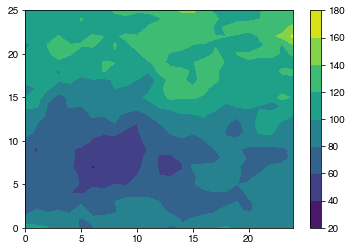

In [116]:
plot_array = whiplash_pic_alltime#+whiplash_hitolo_count_pic
#plot_array = whiplash_hitolo_count_pic
cf=mp.contourf(plot_array)
mp.colorbar(cf)

In [117]:
# whiplash events for RCP runs
whiplash_lotohi_count_hist_rcp = numpy.zeros((180,40,26,25))
whiplash_hitolo_count_hist_rcp = numpy.zeros((180,40,26,25))
for ens_idx in range(40):
    print(ens_idx)
    for lat_idx in range(26):
        for lon_idx in range(25):
            for s in range(180):
                for m in range(5-1):
                    # lo to hi
                    m_val = monthly_data_hist_rcp_NDJFM[ens_idx,lat_idx,lon_idx,s,m]
                    m_plus_one_val = monthly_data_hist_rcp_NDJFM[ens_idx,lat_idx,lon_idx,s,m+1]
                    if ( (m_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                        whiplash_lotohi_count_hist_rcp[s,ens_idx,lat_idx,lon_idx]+=1
                    if ( (m_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                        whiplash_hitolo_count_hist_rcp[s,ens_idx,lat_idx,lon_idx]+=1

#print(whiplash_lotohi_count_hist_rcp)
whiplash_total_count_hist_rcp = whiplash_lotohi_count_hist_rcp + whiplash_hitolo_count_hist_rcp
whiplash_total_count_hist_rcp = numpy.sum(whiplash_total_count_hist_rcp, axis=0)
whiplash_total_count_hist_rcp = numpy.sum(whiplash_total_count_hist_rcp, axis=0)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


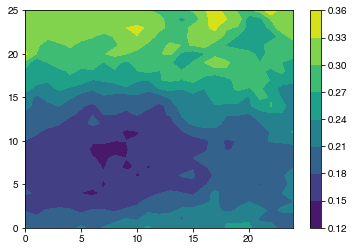

In [118]:
cf=mp.contourf(whiplash_total_count_hist_rcp/1798)
mp.colorbar(cf)

# Whiplash for 2003-2033 and 2070-2100

# Calculate whiplash ratios relative to PIC

In [119]:
whiplash_hist_rcp_alltime = numpy.sum((whiplash_lotohi_count_hist_rcp + whiplash_hitolo_count_hist_rcp), axis=1)
print(whiplash_hist_rcp_alltime.shape)
#print(whiplash_hist_rcp_alltime.shape)
whiplash_hist_rcp_2003_2033 = numpy.sum(whiplash_hist_rcp_alltime[idx_2003:idx_2033,:,:], axis=0)
whiplash_hist_rcp_2070_2100 = numpy.sum(whiplash_hist_rcp_alltime[idx_2070:idx_2100,:,:], axis=0)

# whiplash events for pic runs
whiplash_pic = whiplash_lotohi_count_pic + whiplash_lotohi_count_pic

pic_freq = (whiplash_pic_alltime/1798)
# times per century for RCP8.5-like warming
rcp_freq_2003_2033 = (whiplash_hist_rcp_2003_2033/(40*30))
rcp_freq_2070_2100 = (whiplash_hist_rcp_2070_2100/(40*30))

wr_2003_2033 = rcp_freq_2003_2033/pic_freq
wr_2070_2100 = rcp_freq_2070_2100/pic_freq

(180, 26, 25)


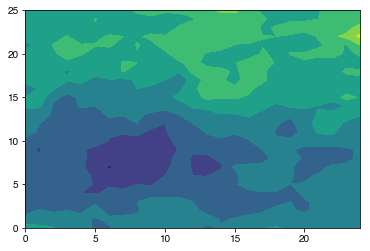

In [120]:
mp.contourf(whiplash_pic_alltime)

# Calculate whiplash ratios for only LO to HI events

In [121]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [122]:
# make color map
minval=0.05 # 
maxval=0.95 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

# Plot 2003-2033

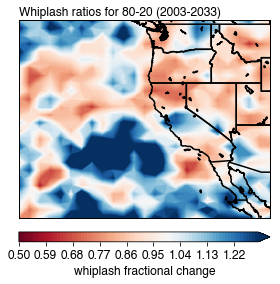

In [123]:
fontsize=12
contour_levels = numpy.arange(0.5,1.31,0.01)

fig = mp.figure(figsize=(4,4))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, wr_2003_2033, \
                      cmap='RdBu', \
                      zorder=2, \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      extend='max',\
                      latlon=True)
#pr_contours = map.contour(xi, yi, wr_2003_2033, levels=[0.5,1.0,1.5,2.0], colors='0.1', alpha=1, linewidth=[1,1,1,1], linestyles=['--',':','-','-'])

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('whiplash fractional change', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks([0,0.5,1.,1.5,2.])

ax.text(s='Whiplash ratios for 80-20 (2003-2033)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()

#fig.text(s='Whiplash ratios for 80-20', x=0.5, y=0.98, ha='center', va='bottom', fontsize=fontsize, transform=fig.transFigure)
#mp.savefig('monthly_whiplash_ratios_8020_2003-2033.pdf', transparent=True, bbox_inches='tight')

# Plot 2070-2100

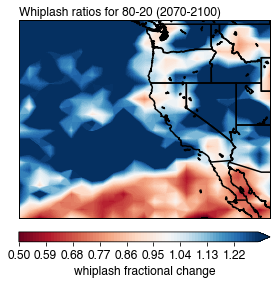

In [124]:
fontsize=12
contour_levels = numpy.arange(0.5,1.31,0.01)

fig = mp.figure(figsize=(4,4))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

pr_map = map.contourf(xi, yi, wr_2070_2100, \
                      cmap='RdBu', \
                      zorder=2, \
                      norm=MidpointNormalize(midpoint=1.0), \
                      levels=contour_levels, \
                      extend='max', \
                      latlon=True)
#pr_contours = map.contour(xi, yi, wr_2003_2033, levels=[0.5,1.0,1.5,2.0], colors='0.1', alpha=1, linewidth=[1,1,1,1], linestyles=['--',':','-','-'])

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('whiplash fractional change', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks([0,0.5,1.,1.5,2.])

ax.text(s='Whiplash ratios for 80-20 (2070-2100)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()

#fig.text(s='Whiplash ratios for 80-20', x=0.5, y=0.98, ha='center', va='bottom', fontsize=fontsize, transform=fig.transFigure)
#mp.savefig('monthly_whiplash_ratios_8020_2003-2033.pdf', transparent=True, bbox_inches='tight')

# Calculate time-latitude array

In [125]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

In [126]:
# pull out cali coast data
wr_2070_2100_cali_coast = wr_2070_2100[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]].reshape((11,3))
print(wr_2070_2100_cali_coast.shape)
whiplash_hist_rcp_2003_2033 = numpy.sum(whiplash_hist_rcp_alltime[idx_2003:idx_2033,:,:], axis=0)

(11, 3)


# Loop through 30-yr chunks and perform whiplash counts

In [186]:
# go through 30-year chunks
window=30
time_lat_wr_ratios = numpy.zeros((11,180-window))

pic_freq = whiplash_pic_alltime/1798
print(whiplash_pic_alltime.shape, whiplash_hist_rcp_alltime.shape)

for yr_idx in range(180-window):
    whiplash_window = numpy.sum(whiplash_hist_rcp_alltime[yr_idx:(yr_idx+30),:,:], axis=0)
    #print(whiplash_window.shape)
    #cf=mp.contourf(whiplash_window)
    #mp.colorbar(cf)
    whiplash_freq = whiplash_window/(40*window)
    whiplash_ratio = whiplash_freq/pic_freq
    time_lat_wr_ratios[:,yr_idx] = numpy.mean(whiplash_ratio[cali_coast_latlon_indices[:,0],\
                                              cali_coast_latlon_indices[:,1]].reshape((11,3)), \
                                              axis=1)
    #time_lat_wr_ratios[:,yr_idx] = numpy.mean(whiplash_ratio[cali_coast_latlon_indices[:,0],cali_coast_latlon_indices[:,1]].reshape((3,11)), axis=0)



(26, 25) (180, 26, 25)


In [189]:
pic_freq = whiplash_pic_alltime/1798
#cf= mp.contourf(whiplash_pic_alltime)
#mp.colorbar(cf)

#cf=mp.contourf(pic_freq)
#mp.colorbar(cf)

time_lat_pic_wr_ratios = numpy.zeros((11,1798-window))

for yr_idx in range(1798-window):
    print(whiplash_pic[yr_idx:(yr_idx+window),:,:].shape)
    whiplash_window = numpy.sum(whiplash_pic[yr_idx:(yr_idx+window),:,:], axis=0)
    whiplash_freq = whiplash_window/window
    whiplash_ratio = whiplash_freq/pic_freq
    time_lat_pic_wr_ratios[:,yr_idx] = numpy.mean(whiplash_ratio[cali_coast_latlon_indices[:,0],\
                                                 cali_coast_latlon_indices[:,1]].reshape((11,3)),\
                                                 axis=1)

print(whiplash_ratio.shape)


(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 

(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 26, 25)
(2, 

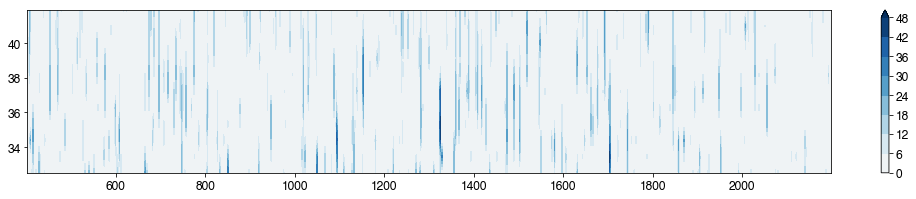

In [187]:
fontsize=12

fig = mp.figure(figsize=(18,3))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=fontsize)

contour_levels = numpy.arange(0.,2.01,0.01)
cf = ax.contourf(numpy.arange(402+window/2,2200-window/2), \
                 PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                 time_lat_pic_wr_ratios, \
                 norm=MidpointNormalize(midpoint=1.0), \
                 cmap='RdBu', \
                 extend='max', \
                 #levels=contour_levels, \
                 )

cbar = mp.colorbar(cf)
cbar.ax.tick_params(labelsize=fontsize)

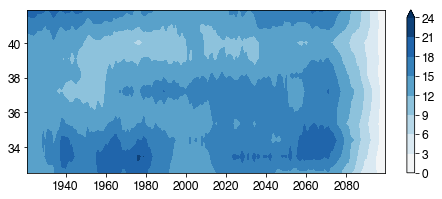

In [185]:
fontsize=12

#cf=mp.contourf(numpy.arange(1935,2085), PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], time_lat_wr_ratios)
fig = mp.figure(figsize=(8,3))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=fontsize)

contour_levels = numpy.arange(0.55,1.31,0.01)
cf = ax.contourf(numpy.arange(1920+window/2,2100-window/2), \
                 PRECT_lat[numpy.unique(cali_coast_latlon_indices[:,0])], \
                 time_lat_wr_ratios, \
                 norm=MidpointNormalize(midpoint=1.0), \
                 cmap='RdBu', \
                 extend='max', \
                 #levels=contour_levels, \
                 )

cbar = mp.colorbar(cf)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(numpy.arange(contour_levels.min(), contour_levels.max()+0.1,0.1))

In [ ]:
# save hist clim
filename = 'whiplash_ratios_8020.nc'

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat.size)
lon_dim = ncfile.createDimension('lon', PRECT_lon.size)

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lat_var[:] = PRECT_lat
lon_var[:] = PRECT_lon
lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

whiplash_total_hist_rcp_var = ncfile.createVariable('whiplash_hist_rcp', 'f4', ('lat','lon'))
whiplash_total_hist_rcp_var[:] = whiplash_total_count_hist_rcp
whiplash_total_hist_rcp_var.units = 'unitless'
whiplash_total_hist_rcp_var.description = 'Total number of whiplash events during historical and RCP8.5 time period'

ncfile.history = 'Created ' + time.ctime(time.time())
ncfile.close()
print(filename, "saved")